In [8]:
import sys
!{sys.executable} -m pip install graphviz;
!{sys.executable} -m pip install pydotplus;
!{sys.executable} -m pip install category_encoders;

import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

import category_encoders as ce

import os

import matplotlib.pyplot as plt
import seaborn as sn

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

---

## I. Introdução

O câncer de mama, segundo o Instituto Nacional do Câncer (INCA), é tumor mais frequente entre mulheres, e o que apresenta a maior letalidade. Estágios graves, porém, podem ser prevenidos através de tratamento, sendo eficazes em até 95% das vezes e tornando evidente a importância de se realizar exames preventivos e em estágios iniciais para o devido tratamento da doença.

Tendo isso em mente, nosso projeto buscará prever, a partir de um diagnóstico de uma paciente com câncer de mama, se o caso em questão se trata ou não de uma reincidência da doença. Com essa previsão, poderá ser estimado qual o diagnóstico usual de pacientes com recorrência de câncer e usá-lo como base para os diagnósticos preventivos, além de indicar quais pacientes podem necessitar de atenção especial após seu tratamento, caso seu diagnóstico acuse uma possível reincidência.

---

## II. Base de dados

A base de dados contendo o diagnóstico das pacientes foi adquirida no site Kaggle, estando publicamente disponível na seguinte url: https://www.kaggle.com/devraikwar/breast-cancer-diagnostic

In [53]:
# Carregando os dados
dados = pd.read_csv('breast_cancer_diagnosis.csv')
dados.head()

,Start Age,End Age,menopause,Start tumor size,End tumor size,Start_env_nodes,end_env_nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40,49,premeno,15,19,0,2,yes,3,right,left_up,no,recurrence-events
1,50,59,ge40,15,19,0,2,no,1,right,central,no,no-recurrence-events
2,50,59,ge40,35,39,0,2,no,2,left,left_low,no,recurrence-events
3,40,49,premeno,35,39,0,2,yes,3,right,left_low,yes,no-recurrence-events
4,40,49,premeno,30,34,3,5,yes,2,left,right_up,no,recurrence-events


In [54]:
dados.shape

(286, 13)

#### Checando valores nulos

In [55]:
dados.isnull().sum().sum()

9

In [56]:
#Como o numero de NaNs é relavtivamente baixo quando comparados ao tamanho da database, podemos exluí-las sem maiores perdas
dados = dados.dropna()

#### Melhorando a base de dados

In [57]:
#Juntando colunas categóricas separadas
dados['age_group'] = dados['Start Age'].astype('string') + '-' + dados['End Age'].astype('string')
dados['env_nodes_group'] = dados['Start_env_nodes'].astype('string') + '-' + dados['end_env_nodes'].astype('string')
dados['tumor_size'] = dados['Start tumor size'].astype('string') + '-' + dados['End tumor size'].astype('string')

#Deletando colunas que não serão utilizadas, já que seu conteúdo foi adicionado a outra coluna
del dados['End Age']
del dados['Start Age']
del dados['Start_env_nodes']
del dados['end_env_nodes']
del dados['Start tumor size']
del dados['End tumor size']

#Atribuindo à variável target a coluna class
target = dados.pop('Class')
dados.insert(9,'Class',target)

#Renomeando a coluna class
dados.rename(columns = {'Class':'recurrent_events'}, inplace=True)

dados.head()

,menopause,node-caps,deg-malig,breast,breast-quad,irradiat,age_group,env_nodes_group,tumor_size,recurrent_events
0,premeno,yes,3,right,left_up,no,40-49,0-2,15-19,recurrence-events
1,ge40,no,1,right,central,no,50-59,0-2,15-19,no-recurrence-events
2,ge40,no,2,left,left_low,no,50-59,0-2,35-39,recurrence-events
3,premeno,yes,3,right,left_low,yes,40-49,0-2,35-39,no-recurrence-events
4,premeno,yes,2,left,right_up,no,40-49,3-5,30-34,recurrence-events


Com a visualização da base de dados melhorada, a legenda para cada coluna é:

- `menopause`: momento de menopausa da paciente.
- `node-caps`: presença do tumor nos gânglios linfáticos ou não.
- `deg-malig`: grau histológico de malignidade.
- `breast`: mama afetada.
- `breast-quad`: admitindo o mamilo como ponto central, o quartil do peito com região afetada.
- `irradiat`: paciente foi submetida a radioterapia ou não.
- `age_group`: faixa de idade.
- `env_nodes_group`: faixa do número de gânglios linfáticos auxiliares apresentando tumor.
- `tumor-size`: faixa do tamanho do tumor, em mm.
- `recurrent_events`: variável target — classificação se a paciente apresenta ou não reicidência de câncer.

---

## III. Análise exploratória

Vamos explorar a relação entre as variáveis features com a variável target.

Como todas as variáveis são categóricas, iremos utilizar tabelas cruzadas.

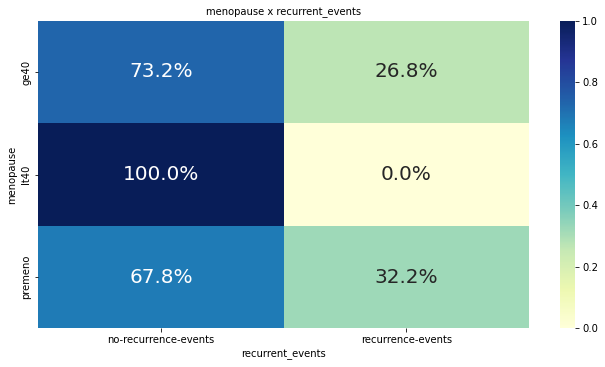

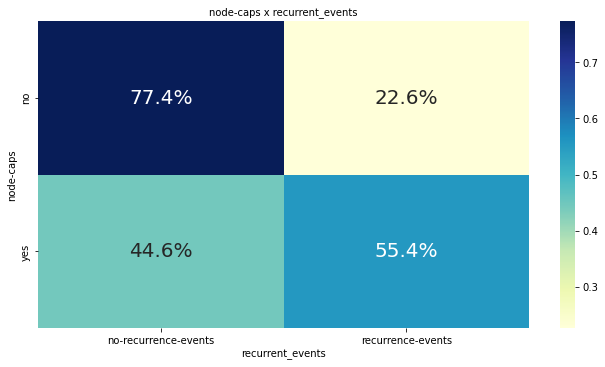

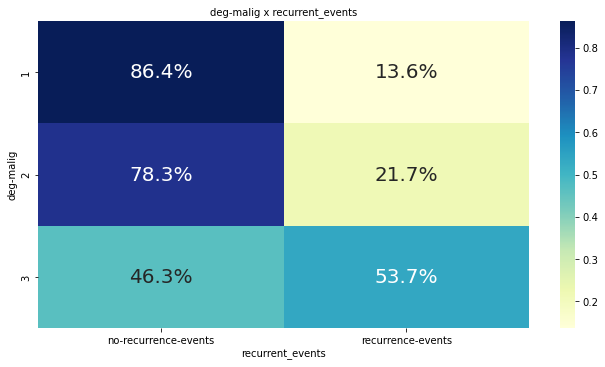

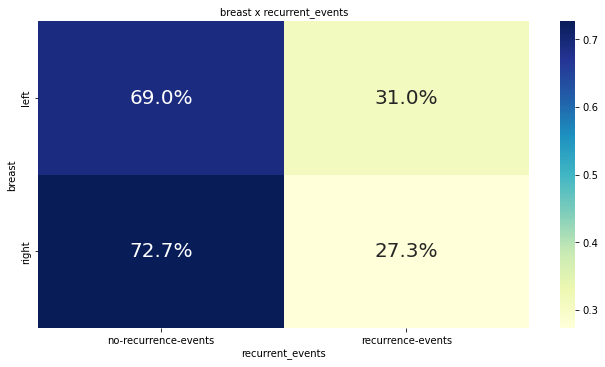

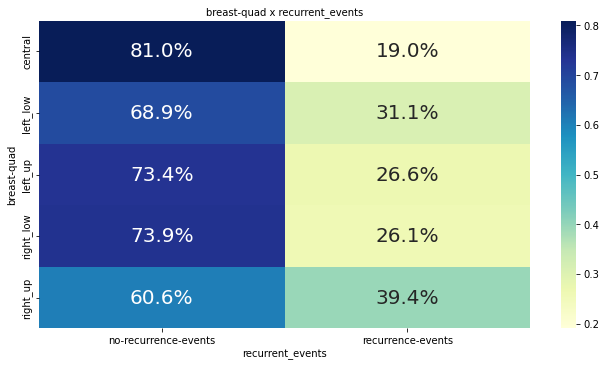

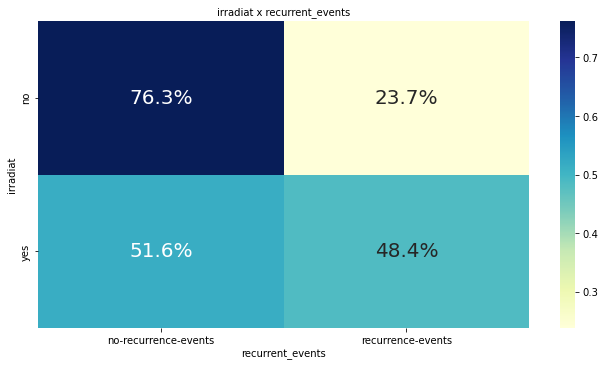

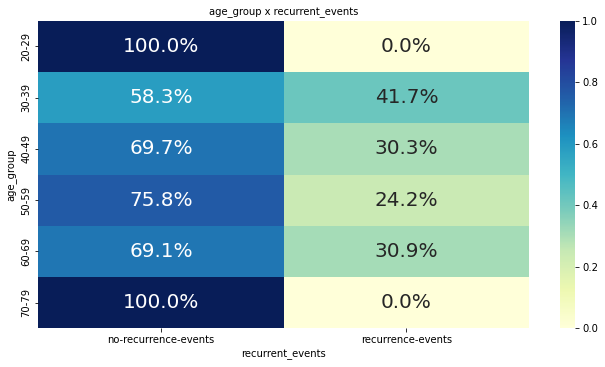

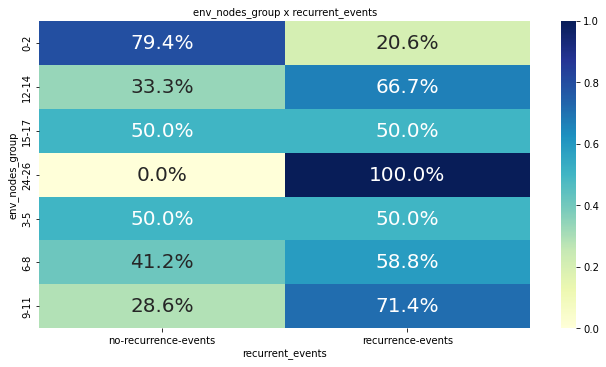

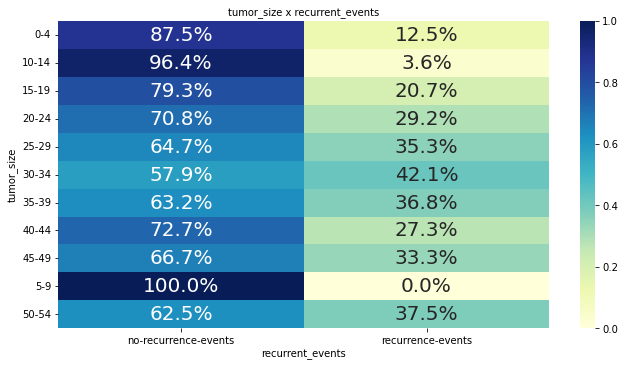

In [58]:
#Definindo features
features = ['menopause','node-caps','deg-malig','breast', 'breast-quad', 'irradiat','age_group','env_nodes_group','tumor_size']

# Matriz de confusão que relaciona a target com as duas primeiras features
for i, feature in enumerate(features):
    plt.figure(figsize = (11,60))
    plt.subplot(9,1,i+1)
    df_cm=pd.crosstab(dados[feature],dados['recurrent_events'],normalize='index')
    plt.title(f'{features[i]} x recurrent_events',fontdict={'fontsize': 10})
    sn.heatmap(df_cm, annot=True, annot_kws={"size":20},fmt='.1%',cmap='YlGnBu')
    if i == 8:
        break

##### **Insights** 

As variáveis `tumor-size` e `deg-malig` aparentam apresentar um padrão entre a distribuição de pacientes sem e com recorrência de eventos:

- Quanto maior a classificação do `deg-malig`, maior a porcentagem de pacientes com recorrência de eventos para essa característica
- Para valores mais centrais do `tumor-size`, maior a porcentagem de pacientes com recorrência de eventos para essa característica


---

## IV. Modelo de classificação Decision Tree

Como uma tentativa de prever a variável target, será utilizado o modelo Decision Tree.

A função "Decision Tree Classifier" é um método de aprendizado usado para classificação e regressão. 
O objetivo é criar um modelo que prediz o valor de uma variável-alvo pelo aprendizado de regras de decisão simples, referidas como "data features". 
Uma árvore pode ser vista como uma aproximação constante por partes.

#Algumas vantagens de utilizar Decision Trees são:

-Fácil de entender e de interpretar, árvores podem ser visualizadas.

-Capaz de lidar com dados categóricos e numéricos, apesar da implementação sciki-tlearn ainda não suportar variáveis categóricas.

-Utiliza um modelo de caixa branca. Se uma situação dada é observável em um modelo, a explicação para a condição é facilmente explicada pela lógica booleana. Por contraste, num modelo de caixa preta (como a uma rede neural artificial) os resultados podem ser mais difíceis de interpretar.

-Possibilidade de validar o modelo utilizando testes estatísticos. Isso torna possível contabilizar a confiabilidade do modelo.

#Algumas desvantagens das Decision Trees:

-Decision Tree learners podem criar árvores extremamente complicadas que não generalizam os dados muito bem.

-Predições das árvores de decisão não são suaves nem contínuas, mas feitas por aproximações constantes por partes.

-Decision Trees podem ser instáveis pois pequenas variações nos dados podem resultar na geração de uma árvore completamente diferente. 

#### a) Definindo parâmetros

In [63]:
#definindo os dummies para as variaveis categoricas:
dummies = pd.get_dummies(dados['breast-quad'])
dados = dados.join(dummies)
# Definindo as features e separando a base de dados entre treinamento e teste
features = ['menopause','node-caps','deg-malig','breast','irradiat','age_group','env_nodes_group','tumor_size','central','left_low','left_up','right_low','right_up']
X = dados[features]
y = dados.recurrent_events

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% treinamento e 30% teste
dados

,menopause,node-caps,deg-malig,breast,breast-quad,irradiat,age_group,env_nodes_group,tumor_size,recurrent_events,central,left_low,left_up,right_low,right_up
0,premeno,yes,3,right,left_up,no,40-49,0-2,15-19,recurrence-events,0,0,1,0,0
1,ge40,no,1,right,central,no,50-59,0-2,15-19,no-recurrence-events,1,0,0,0,0
2,ge40,no,2,left,left_low,no,50-59,0-2,35-39,recurrence-events,0,1,0,0,0
3,premeno,yes,3,right,left_low,yes,40-49,0-2,35-39,no-recurrence-events,0,1,0,0,0
4,premeno,yes,2,left,right_up,no,40-49,3-5,30-34,recurrence-events,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,ge40,yes,2,left,left_low,no,50-59,6-8,30-34,no-recurrence-events,0,1,0,0,0
282,premeno,yes,2,left,left_low,yes,50-59,3-5,25-29,no-recurrence-events,0,1,0,0,0
283,premeno,yes,2,right,right_up,no,30-39,6-8,30-34,no-recurrence-events,0,0,0,0,1
284,premeno,no,2,right,left_low,no,50-59,0-2,15-19,no-recurrence-events,0,1,0,0,0


#### b) Codificando variáveis categóricas

In [64]:
# definindo o codificador
encoder = ce.OrdinalEncoder(cols=['menopause','node-caps','deg-malig','breast','irradiat','age_group','env_nodes_group','tumor_size'])

#criando dummies para o quadrante:
dummies = pd.get_dummies(dados['breast-quad'])
# codificando X_train e X_test
X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

X_train.head()

,menopause,node-caps,deg-malig,breast,irradiat,age_group,env_nodes_group,tumor_size,central,left_low,left_up,right_low,right_up
195,1,1,1,1,1,1,1,1,1,0,0,0,0
99,1,1,2,1,1,2,2,2,0,0,1,0,0
113,1,1,3,1,2,1,1,3,0,0,0,0,1
72,2,1,2,1,1,3,2,4,0,1,0,0,0
197,3,1,2,2,1,3,2,5,0,1,0,0,0


#### c) Aplicando o modelo

In [65]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

#### d) Explorando resultados

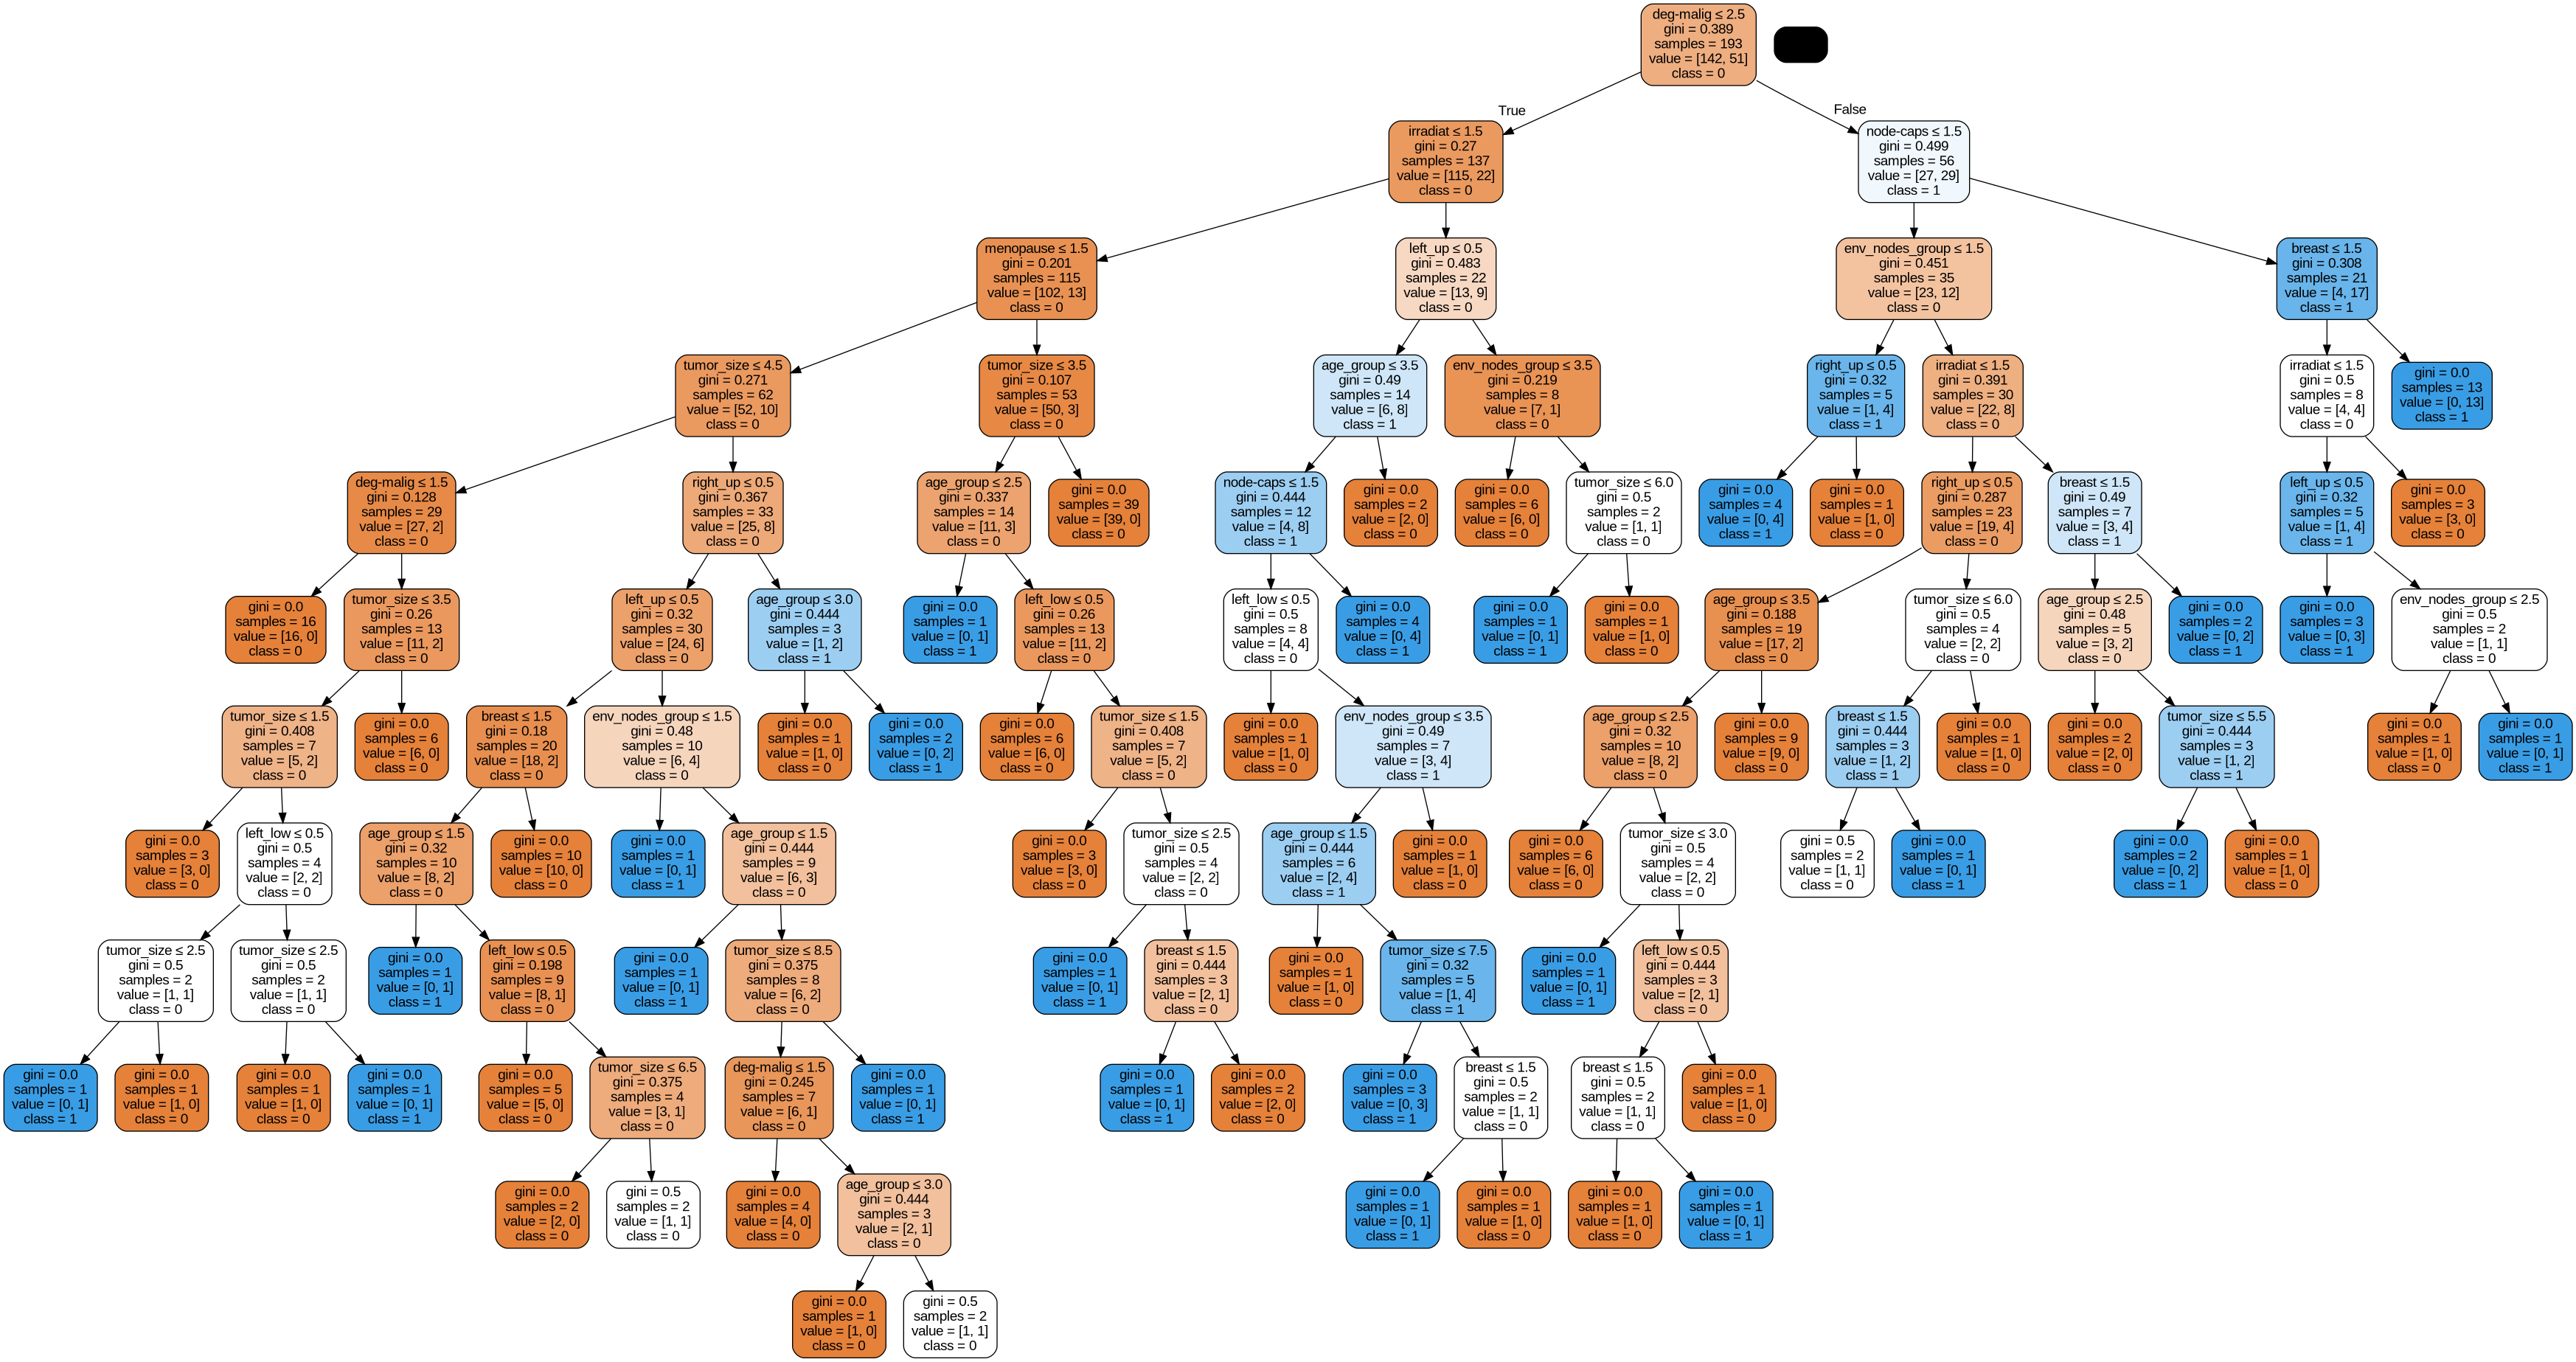

In [66]:
# Gerando a imagem da Decision Tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Cancer.png')
Image(graph.create_png())

**Matriz de confusão:**

/home/rafalimao/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


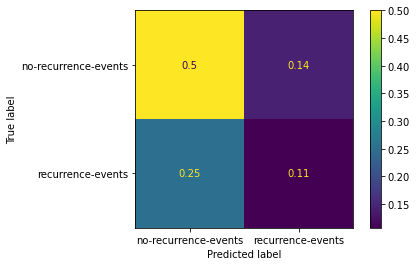

In [67]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, normalize='all')  
plt.show()

In [68]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6071428571428571


A partir dos resultados obtidos pela matriz de confusão, ficou notório que o modelo teve um ótimo desempenho ao classificar as variáveis target que representam os eventos não-recorrentes, considerando-se que esse tipo de evento foi o mais comum na base de dados. No entanto, percebe-se que houve uma certa tendência de classificar os eventos recorrentes como não-recorrentes. Isso se deve, em parte, pelo fato de que, como na base de dados não haviam muitas amostras de eventos recorrentes, menos dados foram utilizados para o treinamento do algoritmo, de forma que a classificação dos eventos recorrentes tenha sido impactada negativamente, representando, então, uma eficácia de um pouco mais de terço.

---

## V. Modelo de classificação Random Forest Classifier

Como outra tentativa de prever a variável target, também será utilizado o modelo Random Forest Classifier.

Random forests ou random decision forests são um conjunto de métodos de aprendizado para classificação, regressão e outras tarefas que operam 
pela construção de uma multidão de decision trees no tempo de treinamento. Para tarefas de classifcação, o output da random forest é a 
classe selecionada pela maioria das árvores. Para tarefas de regressão, o retorno é a média prediziada pelas árvores individuais.
Random decision forests corrigem o hábito de overfitting das decision trees. 
Random forests geralmente melhoram a perfomance das decision trees, mas a acurácia é mais baixa que os gradientes aumentados das árvores. 
No entando, as características dos dados podem afetar suas perfomances.

O primeiro algoritmo para random decision forests foi criado em 1995 pelo Tin Kam Ho, utilizando o random subspace method, no qual, na formulação de Ho's, 
é um caminho para implementar a abordagem de classificação "discriminação estocástica" proposta por Eugene Kleinberg. ##

#### a) Aplicando o modelo

Não é necessário definir os parâmetros ou codificar as variáveis pois será usado os mesmos parâmetros do modelo anterior

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Montando uma Random Forest com 1000 Decision Trees
clf=RandomForestClassifier(n_estimators=1000)

# estabelecendo os parâmetros no modelo
clf.fit(X_train,y_train)

# treinando o modelo
y_pred=clf.predict(X_test)

#### b) Explorando resultados

**Scores de relevância das features:**

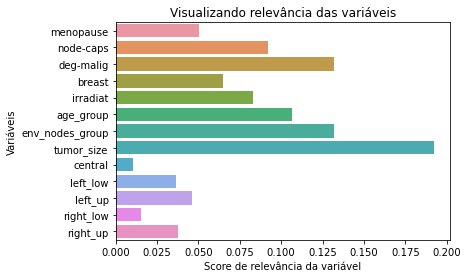

In [70]:
%matplotlib inline

# com base nos resultados do modelo, adquirindo a relevância de cada variável
feature_import =(clf.feature_importances_)

# criando o eixo x
sn.barplot(x=feature_import, y=features)
# Add labels to your graph
plt.xlabel('Score de relevância da variável')
plt.ylabel('Variáveis')
plt.title("Visualizando relevância das variáveis")
plt.show()

**Matriz de confusão:**

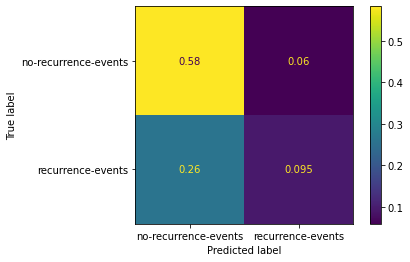

In [28]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, normalize='all')  
plt.show()

In [29]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6785714285714286


Neste modelo, por sua vez, observa-se um comportamento semelhante ao obtido com o modelo da Árvore de Decisão. O percentual dos eventos não-recorrentes classificados de tal forma novamente foi bastante assertivo, sendo que os eventos desse tipo que foram classificados como recorrentes diminuíram ainda mais. Entretanto, essa maior assertividade está diretamente relacionada ao fato de que o percentual dos verdadeiros-positivos teve uma sutil queda, impactando no maior número de eventos recorrentes classificados erroneamente.

---

## VI. Conclusões

Bla bla bla bla bla bla bla

---

## VII. Referências Bibliográficas

CHAURASIA, Vikas; PAL, Saurabh. Data mining techniques: to predict and resolve breast cancer survivability. International Journal of Computer Science and Mobile Computing IJCSMC, v. 3, n. 1, p. 10-22, 2014.

INCA. Câncer de mama, conceito e magnitude. Disponível em: https://www.inca.gov.br/controle-do-cancer-de-mama/conceito-e-magnitude. Acessado em 26/11/2021

https://scikit-learn.org/stable/modules/tree.html#tree

https://en.wikipedia.org/wiki/Random_forest